In [1]:
# set up the python
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm
import cartopy.feature as cft
import cftime
import IPython.display
import sys, os, warnings

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36635,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://10.0.128.142:43669,Total threads: 4
Dashboard: /proxy/42297/status,Memory: 11.23 GiB
Nanny: tcp://127.0.0.1:34743,


In [3]:
# load the MOM6 data 
db='/g/data/ik11/outputs/mom6-panan/panant.db' 
expts = ['panant-v2','panant-01-hycom1','panant-01-zstar']

In [4]:
session = cc.database.create_session()

In [5]:
# time period
start_time = '1995-01-01'
end_time = '1996-01-01'

In [6]:
# get the depth
depth = cc.querying.getvar('panant-01-zstar','deptho',session,n=1)
land_mask = np.squeeze(depth.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

# Test MOM6 at first, uo, dy and dz

In [7]:
# get 
uo = cc.querying.getvar('panant-01-hycom1','uo',session,start_time=start_time, end_time=end_time)

In [8]:
dy = cc.querying.getvar(expt='panant-01-hycom1', variable='dyCu', 
                          session=session, frequency='static', n=1)
dy

<xarray.DataArray 'dyCu' (yh: 845, xq: 3601)>
dask.array<open_dataset-df0d6c02e9b31de68a9313f10157cf80dyCu, shape=(845, 3601), dtype=float32, chunksize=(845, 3601), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -81.11 -81.07 -81.02 -80.98 ... -37.3 -37.22 -37.14
  * xq       (xq) float64 -280.0 -279.9 -279.8 -279.7 ... 79.7 79.8 79.9 80.0
Attributes:
    units:          m
    long_name:      Delta(y) at u points (meter)
    cell_methods:   time: point
    interp_method:  none
    ncfiles:        ['/g/data/ik11/outputs/mom6-panan/panant-01-hycom1/output...

In [9]:
dz_interface =cc.querying.getvar(expt='panant-01-hycom1', variable='ds_interface', 
                          session=session, n=1)
dz_interface

<xarray.DataArray 'ds_interface' (Interface: 76)>
dask.array<open_dataset-fd9e5776542e6c66afe486c77390ea60ds_interface, shape=(76,), dtype=float64, chunksize=(76,), chunktype=numpy.ndarray>
Coordinates:
  * Interface  (Interface) float64 0.0 1.08 2.16 ... 3.453e+03 3.718e+03 6e+03
Attributes:
    long_name:  Layer Center Coordinate Separation
    units:      meter
    ncfiles:    ['/g/data/ik11/outputs/mom6-panan/panant-01-hycom1/output034/...

In [10]:
# then uo * dy
uo_dy = uo*dy
uo_dy

,Array,Chunk
Bytes,12.75 GiB,19.04 MiB
Shape,"(15, 75, 845, 3601)","(1, 21, 236, 1007)"
Count,2920 Tasks,960 Chunks
Type,float32,numpy.ndarray


In [11]:
# finilay streamfunction = uo * dy*dz
dz = np.arange(75)
zl = uo.z_l

In [12]:
#dz[0] = zl[0]*2.
#dz[1] = (zl[1]-dz[0])*2
#dz[2] = (zl[2]-dz[1]-dz[0])*2

In [13]:
for i in range(74):
    dz[0] = zl[0]*2.
    dz[i+1] = (zl[i+1] - np.sum(dz[:i]))
dz

array([  1,   1,   1,   2,   2,   2,   2,   2,   2,   3,   4,   4,   3,
         3,   4,   6,   7,   6,   6,   7,   8,  10,  11,  11,  11,  13,
        16,  18,  19,  20,  21,  24,  28,  31,  34,  37,  39,  43,  49,
        55,  60,  64,  69,  76,  84,  91,  98, 105, 112, 120, 128, 136,
       143, 149, 154, 160, 167, 173, 177, 179, 180, 183, 188, 192, 193,
       192, 191, 193, 196, 199, 199, 197, 196, 197, 199])

In [14]:
# convert dz it to data array
dz1 = xr.DataArray(data = dz,dims=['z_l'])

lets test the streamfunction at 4000 m depth


In [15]:
# now calculate uo_dydz
uo_dydz = uo_dy*dz1


In [39]:
# 1 year mean flux
flux = uo_dydz.sel(time = slice(start_time,end_time)).sel(yh = slice(-90,-50)).cumsum('yh').mean('time')/1e6
flux = flux.load()

### Now we test streamfunction at (x,y)

In [40]:
# calculate the sum of fluxes at (x,y)
flux1 = flux.sum('z_l').load()

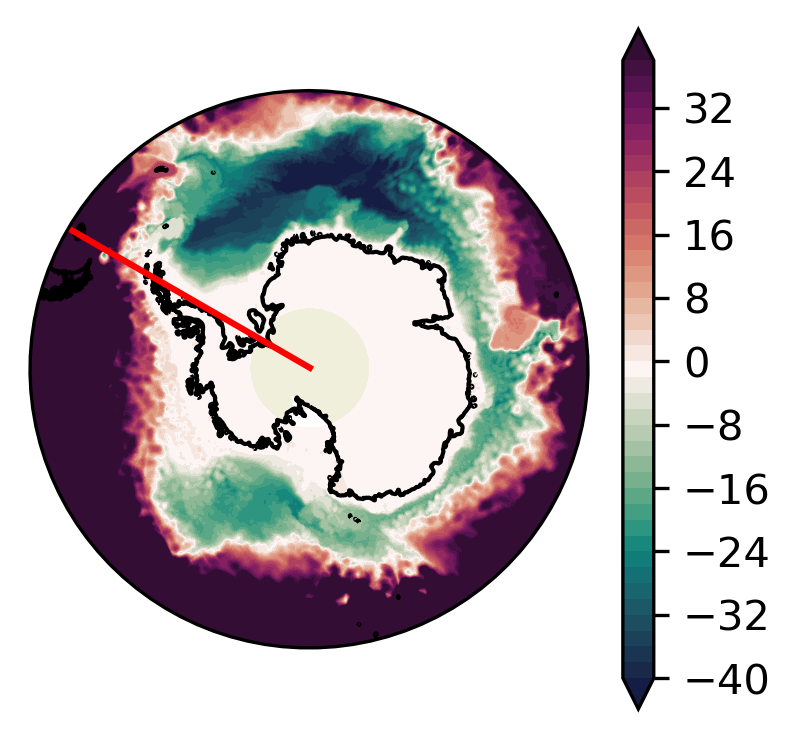

In [41]:
# plot the map
projection=ccrs.SouthPolarStereo()
fig = plt.figure(figsize=(3, 3), dpi=300)

ax = plt.subplot(1,1,1,projection = projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())

theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux1.plot.contourf(ax=ax, levels = np.arange(-40,40,2),transform=ccrs.PlateCarree(),cmap=cm.cm.curl)
ax.plot([-60,-60],[-90,-50],color='r',transform=ccrs.PlateCarree())


### Now we test different transects at depths (y,z)

In [54]:
transect1 = flux.sel(xq = -50, method = 'nearest').load()

In [55]:
transect2 = flux.sel(xq = -30, method = 'nearest').load()

In [56]:
transect3 = flux.sel(xq = 0, method = 'nearest').load()

In [57]:
transect4 = flux.sel(xq = 30, method = 'nearest').load()

In [58]:
transect5 = flux.sel(xq = 60, method = 'nearest').load()

In [59]:
transect6 = flux.sel(xq = -270, method = 'nearest').load()

In [60]:
transect7 = flux.sel(xq = -240, method = 'nearest').load()

In [61]:
transect8 = flux.sel(xq = -210, method = 'nearest').load()

In [62]:
transect9 = flux.sel(xq = -180, method = 'nearest').load()

In [63]:
transect10 = flux.sel(xq = -150, method = 'nearest').load()

Text(0, 0.5, 'streamfunction (Sv)')

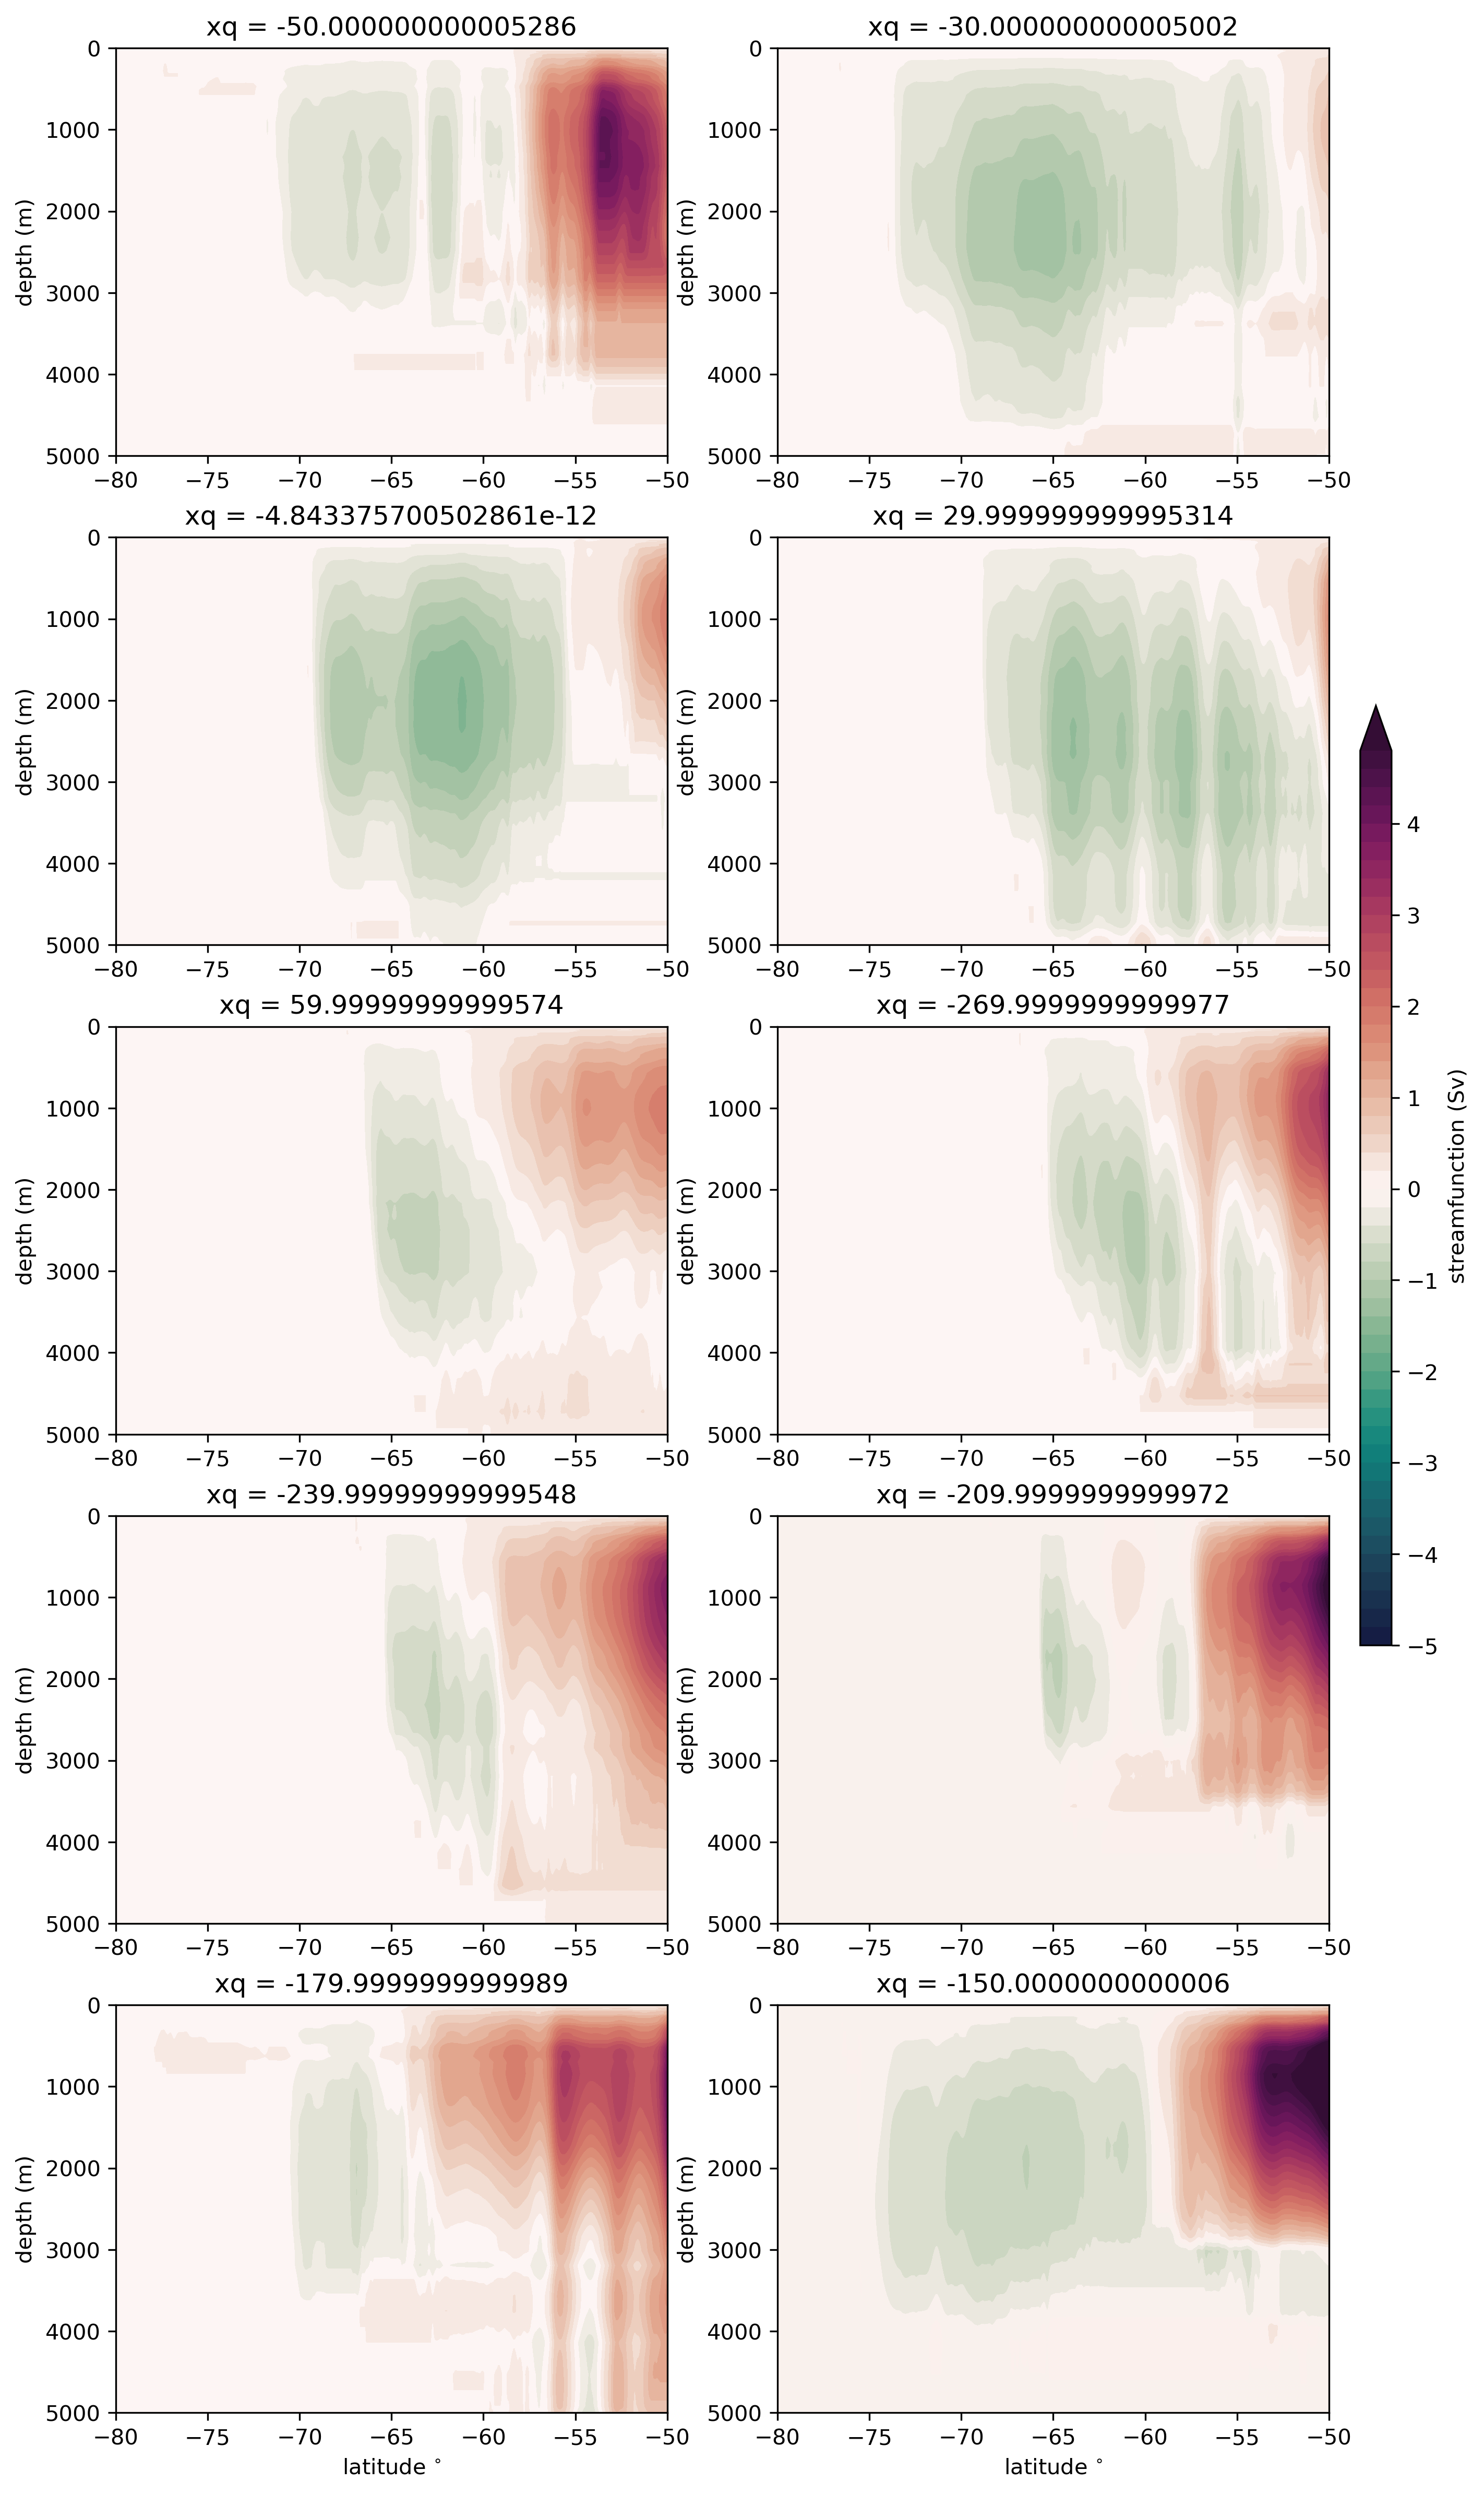

In [68]:
plt.figure(figsize=(10,20),dpi = 300)
#1
ax = plt.subplot(5,2,1)
p1 = transect1.plot.contourf(ax=ax, levels = np.arange(-5,5,0.2),cmap=cm.cm.curl, add_colorbar=False)
plt.ylim(0,5000.)
plt.xlim(-80,-50)
plt.gca().invert_yaxis()
ax.set(xlabel=None)
plt.ylabel('depth (m)')

#2
ax = plt.subplot(5,2,2)
p1 = transect2.plot.contourf(ax=ax, levels = np.arange(-5,5,0.2),cmap=cm.cm.curl, add_colorbar=False)
plt.ylim(0,5000.)
plt.xlim(-80,-50)
plt.gca().invert_yaxis()
ax.set(xlabel=None)
plt.ylabel('depth (m)')

#3
ax = plt.subplot(5,2,3)
p1 = transect3.plot.contourf(ax=ax, levels = np.arange(-5,5,0.2),cmap=cm.cm.curl, add_colorbar=False)
plt.ylim(0,5000.)
plt.xlim(-80,-50)
plt.gca().invert_yaxis()
ax.set(xlabel=None)
plt.ylabel('depth (m)')

#4
ax = plt.subplot(5,2,4)
p1 = transect4.plot.contourf(ax=ax, levels = np.arange(-5,5,0.2),cmap=cm.cm.curl, add_colorbar=False)
plt.ylim(0,5000.)
plt.xlim(-80,-50)
plt.gca().invert_yaxis()
ax.set(xlabel=None)
plt.ylabel('depth (m)')

#5
ax = plt.subplot(5,2,5)
p1 = transect5.plot.contourf(ax=ax, levels = np.arange(-5,5,0.2),cmap=cm.cm.curl, add_colorbar=False)
plt.ylim(0,5000.)
plt.xlim(-80,-50)
plt.gca().invert_yaxis()
ax.set(xlabel=None)
plt.ylabel('depth (m)')

#6
ax = plt.subplot(5,2,6)
p1 = transect6.plot.contourf(ax=ax, levels = np.arange(-5,5,0.2),cmap=cm.cm.curl, add_colorbar=False)
plt.ylim(0,5000.)
plt.xlim(-80,-50)
plt.gca().invert_yaxis()
ax.set(xlabel=None)
plt.ylabel('depth (m)')

#7
ax = plt.subplot(5,2,7)
p1 = transect7.plot.contourf(ax=ax, levels = np.arange(-5,5,0.2),cmap=cm.cm.curl, add_colorbar=False)
plt.ylim(0,5000.)
plt.xlim(-80,-50)
plt.gca().invert_yaxis()
ax.set(xlabel=None)
plt.ylabel('depth (m)')

#8
ax = plt.subplot(5,2,8)
p1 = transect8.plot.contourf(ax=ax, levels = np.arange(-5,5,0.2),cmap=cm.cm.curl, add_colorbar=False)
plt.ylim(0,5000.)
plt.xlim(-80,-50)
plt.gca().invert_yaxis()
ax.set(xlabel=None)
plt.ylabel('depth (m)')

#9
ax = plt.subplot(5,2,9)
p1 = transect9.plot.contourf(ax=ax, levels = np.arange(-5,5,0.2),cmap=cm.cm.curl, add_colorbar=False)
plt.ylim(0,5000.)
plt.xlim(-80,-50)
plt.gca().invert_yaxis()
ax.set(xlabel=None)
plt.ylabel('depth (m)')
plt.xlabel('latitude $^{\circ}$')
#10
ax = plt.subplot(5,2,10)
p1 = transect10.plot.contourf(ax=ax, levels = np.arange(-5,5,0.2),cmap=cm.cm.curl, add_colorbar=False)
plt.ylim(0,5000.)
plt.xlim(-80,-50)
plt.gca().invert_yaxis()
plt.xlabel('latitude $^{\circ}$')
plt.ylabel('depth (m)')


# add the colorabr and legend
# add the colorbar
ax = plt.axes([0.92, 0.37, 0.02, 0.3])
cb = plt.colorbar(p1, cax=ax, orientation='vertical',extend = 'both')
cb.ax.set_ylabel('streamfunction (Sv)')